# Projet Wi-fi UHA

## Sujet:

### Synopsis
Le projet Wi-Fi UHA consiste à analyser les données relatives à l'enregistrement de la puissance du signal Wi-Fi généré par les points d'accès dans le bâtiment C. 

### Données
Les données obtenus à partir du Fipy Pycomm et ont été sauvegardées dans le dossier *data/raw*. Il contient deux dossiers l'un relatif à une série de mesures effectuées au rez-de-chaussée du bâtiment C, l'autre à une série de mesure au premier étage du bâtiment C. 

### Tâches
Les tâches demandées dans ce projet sont les suivantes.

1. Compléter le programme src/data/extract-data.py afin de formater le jeux de données dans un fichier csv.
2. Écrire un programme qui fusionne deux fichiers csv.
3. Établir pour chaque variable le nombre de valeurs manquantes et aberrante ainsi que le pourcentage que cela représente.
4. Établir le nombre et le pourcentage d'observations qui ont des valeurs aberrantes et/ou manquantes.
5. Définir les fonctions ComputeMean et ComputeMedian (*src/model/model.py*) et calculer la moyenne et la médiane de la puissance du signal Wi-Fi du réseau UHA à chaque emplacement où les mesures ont été effectuées.
6. Afficher la heatmap de la puissance du signal Wi-Fi du réseau UHA en fonction des positions où les mesures ont été effectués


## Installation:
**Cloner le repo:**

avec SSH:
```bash
git clone git@github.com:ldsvrn/sae15-wifi.git
```
ou en https:
```bash
git clone https://github.com/ldsvrn/sae15-wifi
```

**Créer l'environnement virtuel:**
```bash
python3 -m venv .venv
source .venv/bin/activate
pip3 install -r requirements.txt
```

**Lancement de Jupyter:**
```bash
.venv/bin/jupyter-notebook
```

**Mise à jour du fichier requirements.txt si nécessaire:**
```bash
pip3 freeze > requirements.txt
```

## Utilisation:
### Parser pour extraire les données brutes:
```bash
src/data/extract-data.py -i *path raw dataset* -o *csv output path*
```
**Code source du script:**
```python
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import argparse


def ExtractFolderName(path):
    return os.path.dirname(path)


def ExtractFileName(path):
    return os.path.basename(path)


def ExtractPlace(folderName):
    return folderName.split("-")[1]


def ExtractDate(folderName):
    temp = folderName.split("-")[2]
    return f"{temp.split('_')[2]}-{temp.split('_')[1]}-{temp.split('_')[0]}" # ISO8601 date format


def ExtractIdExp(fileName):
    return fileName.split("-")[-1]


def ExtractSsid(content):
    return content.split("'")[0][:-1]


def ExtractMacAddr(content):
    return content.split("'")[1]


def ExtractRssi(content):
    return content.split("'")[2]


def ExtractInfo(path):
    folderName = ExtractFolderName(path)  # Extract folder name
    fileName = ExtractFileName(path)  # Extract filename
    result = ""
    descRd = None
    descRd = open(path, "r")
    content = descRd.readlines()
    for idx in content:
        result += f"{ExtractPlace(folderName)},{ExtractDate(folderName)},{ExtractIdExp(fileName)}," \
                  f"{ExtractSsid(idx)},{ExtractMacAddr(idx)},{ExtractRssi(idx)}"
    descRd.close()
    return result


if __name__ == '__main__':
    # declare variables
    isFileCreated = False
    descWr = None
    result = ""
    folderName = ""
    fileName = ""

    # define arguments
    parser = argparse.ArgumentParser(description='Extract information from Wi-Fi logs')
    parser.add_argument("-i", help="path of the input file", required=True)
    parser.add_argument("-o", help="path of the output file", default="../../data/processed/wifi.csv")
    args = parser.parse_args()

    if os.path.isfile(args.i):
        result = ExtractInfo(args.i)
        descWr = open(args.o, "w")
        descWr.write("Location,Date,ExpId,SSID,Addr,RSSI\n")
        descWr.write(result)
        descWr.close()
    elif os.path.isdir(args.i):
        listFiles = os.listdir(args.i)
        for fichier in listFiles:
            if isFileCreated == False:
                descWr = open(args.o, "w")
                descWr.write("Building,Date,ExpId,SSID,Addr,RSSI\n")
                descWr.close()
                isFileCreated = True
            result = ExtractInfo(args.i + fichier)
            descWr = open(args.o, "a")
            descWr.write(result)
            descWr.close()
            result = ""
    else:
        print("Erreur : le fichier ou le dossier n'existe pas")
```


### Script pour fusionner les csv et trier par ExpId:
```bash
src/data/merge-csv.py -i *csv dataset folder* -o *merged csv*
```
**Code source:**
```python
#!/usr/bin/env python3

import os
import argparse
from glob import glob
import pandas as pd

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Merge and sort csv')
    parser.add_argument("-i", help="path of the input folder", required=True)
    parser.add_argument("-o", help="path of the output file", default="wifi-merged.csv")
    args = parser.parse_args()

    files = glob(os.path.join(args.i, "wifi*.csv"))
    print(files)

    df = pd.concat(map(pd.read_csv, files), ignore_index=True).sort_values(by=["ExpId"], ascending=True)
    df.to_csv(args.o, index=False)

```

### Nettoyage et tri des données

On commence par importer la library clean (le fichier est simlink de scr/data/clean.py à notebook/clean.py pour être importé)

In [1]:
import clean

Ensuite, on crée l'objet en précisant l'emplacement du csv, le réseau que l'on souhaite analyser et éventuellement supprimer les doublons.

On peut ensuite lancer le nettoyage et le tri avec la méthode `clean()`.

**Code source de la méthode clean()**
```python
    def clean(self):
        # if null value, delete the row
        temp = len(self.df)
        self.df.dropna(inplace=True)
        self.deleted_null = temp - len(self.df)

        # delete all duplicates
        temp = len(self.df)
        if self.drop_duplicates:
            self.df.drop_duplicates(inplace=True)
        self.deleted_duplicates = temp - len(self.df)

        temp = len(self.df)
        self.df = self.df.loc[(self.df["RSSI"] <= -10) & (self.df["RSSI"] >= -100)]
        self.deleted_RSSI = temp - len(self.df)

        temp = len(self.df)
        self.df = self.df.loc[self.df["SSID"] == self.networks]
        self.deleted_SSID = temp - len(self.df)
```

In [2]:
cleaner = clean.Cleaner("../data/processed/wifi-merged.csv", "uha")

# On récupère le nombres de lignes avant de nettoyer
totalLines = cleaner.get_lines()

# On peut nettoyer et trier:
cleaner.clean()

DEBUG: uha


Grâce à la méthode `get_delete_reason()`, on récupère un dictonnaire décrivant combien de lignes ont été supprimées pour chaque raison.

**Code source de get_delete_reason():**
```python
    def get_delete_reason(self):
        if self.drop_duplicates:
            return {
                "null": self.deleted_null,
                "RSSI": self.deleted_RSSI,
                "duplicates": self.deleted_duplicates,
                "SSID": self.deleted_SSID
            }
        else:
            return {
                "null": self.deleted_null,
                "RSSI": self.deleted_RSSI,
                "SSID": self.deleted_SSID
            }
```

- **"null"** pour les lignes comportant une cellule vide
- **"duplicates"** pour le lignes doublons (seulement si la suppression est activée)
- **"RSSI"** pour les valeurs de RSSI aberrantes (pas entre -100 et -10, les limites du 802.11)
- **"SSID"** pour les valeurs d'autres réseaux que ceux précisés

In [3]:
cleaner.get_delete_reason()

# On la stocke dans une variable pour réutiliser les données facilement
delete_reason = cleaner.get_delete_reason()

On peut donc écrire un petit algorithme pour afficher ces données. *(ici on utilise pas de graphique matplotlib car les valeurs sont trop eloignées pour être visibles correctement)*

In [4]:
total_deleted= cleaner.get_total_deleted()

print(f"Parmis les {total_deleted} valeurs supprimées:")
for i in delete_reason:
    print(f"- {delete_reason[i]} on été supprimés pour {i} (soit {round(delete_reason[i]/total_deleted*100, 3)}%)")

Parmis les 4147 valeurs supprimées:
- 1 on été supprimés pour null (soit 0.024%)
- 4 on été supprimés pour RSSI (soit 0.096%)
- 4142 on été supprimés pour SSID (soit 99.879%)


Après avoir trié ces données, nous pouvons les exporter grâce à la méthode `to_csv()`
```python
   def to_csv(self, output_path):
        self.df.to_csv(output_path, index=False)
```

In [8]:
cleaner.to_csv("../data/cleaned/wifi-uha.csv")

### Modèle (model.py)
Une fois que nos données sont nettoyées et triées, nous pouvons commencer à calculer des moyennes et des médianes en fonction de l'emplacement. La classe `Model` situé dans `scr/model/model.py` propose des méthode pour cela.

In [3]:
import model

m_uha = model.Model("../data/cleaned/wifi-uha.csv")

- **Calcul des moyennes/médianes:**
```python
    def mean_loc(self, location):
        return self.df.loc[(self.df["ExpId"] >= location) & (self.df["ExpId"] < location + 1)]["RSSI"].mean()

    def median_loc(self, location):
        return self.df.loc[(self.df["ExpId"] >= location) & (self.df["ExpId"] < location + 1)]["RSSI"].median()

    def mean_floor(self, floor):
        return self.df.loc[self.df["Building"] == floor]["RSSI"].mean()

    def median_floor(self, floor):
        return self.df.loc[self.df["Building"] == floor]["RSSI"].median()
```
Grâce aux méthodes `mean_loc()` et `median_loc()`, nous pouvons calculer la moyenne et la médiane de la puissance de tous les AP capté à un endroit spécifique (ExpId).
Également, avec les méthodes `mean_floor()` et `median_floor()`, nous pouvons calculer ces valeurs avec les puissances en fonction des étages (`rdc` et `premier`).

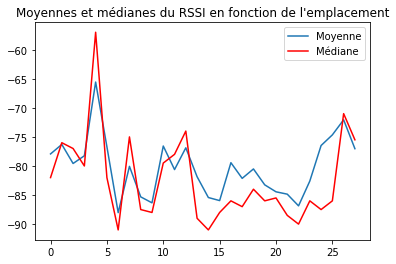

In [4]:
# Nous pouvons donc faire des graphiques de ces valeurs avec matpotlib
import matplotlib.pyplot as plt

mean = []
med = []
for i in range(28):  # Car les ExpId vont de 0 à 27
    mean.append(m_uha.mean_loc(i))
    med.append(m_uha.median_loc(i))
    
plt.plot(mean)
plt.plot(med, color='r')
plt.legend(["Moyenne", "Médiane"])
plt.title("Moyennes et médianes du RSSI en fonction de l'emplacement")
plt.show()

Le problème avec ces moyennes et médianes, c'est qu'elles ne représentent pas complétement la réalité. En effet, elles prennent en compte tous les AP à un point précis, non pas la réception à un point donné (car un ordinateur se connecte à l'AP qui à une meilleure reception. 

Pour remédier à cela, la méthode `get_most_powerful(self, location)` revoie l'adresse MAC de l'AP qui à le meilleur RSSI à un point donné et la méthode `mean_mac_loc(self, mac_address, location)` revoie la moyenne des RSSI d'un AP à un point précis.

Cela nous permet donc, en combinant ces deux méthodes de calculer puissance moyenne à un endroit précis. Par exemple pour la puissance moyenne à l'ExpId 0:

In [5]:
m_uha.mean_mac_loc(m_uha.get_most_powerful(0), 0)

-66.75

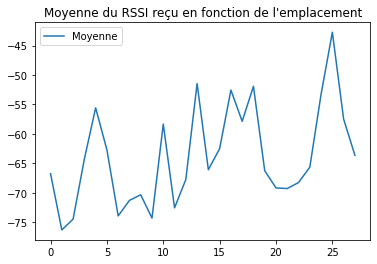

In [6]:
mean = []
for i in range(28):
    mean.append(m_uha.mean_mac_loc(m_uha.get_most_powerful(i), i))
    
plt.plot(mean)
plt.legend(["Moyenne"])
plt.title("Moyenne du RSSI reçu en fonction de l'emplacement")
plt.show()

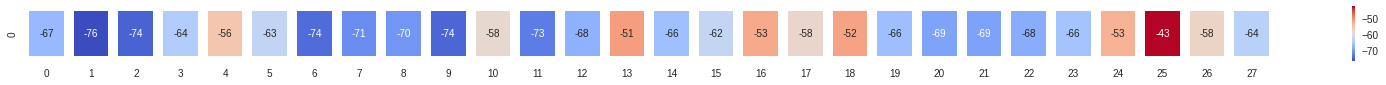

In [19]:
import seaborn as sns
import numpy as np

mean = []
for i in range(28):
    mean.append(m_uha.mean_mac_loc(m_uha.get_most_powerful(i), i))

plt.style.use("seaborn")
plt.figure(figsize=(28,1))

data = np.asarray(mean).reshape(1,28)
heat_map = sns.heatmap(data, linewidths=10, annot = True, cmap="coolwarm")
plt.savefig("../output/heatmap.png", dpi=600, transparent=True)
plt.show()